In [1]:
import base64
import bisect
import itertools as it
import math
import matplotlib.pyplot as plt
import matplotlib.animation as anim
import more_itertools as mt
import numpy as np
import numpy.linalg as npla
import random
import seaborn as sns
import scipy.integrate as sciint
import sys
from tempfile import NamedTemporaryFile
%matplotlib inline

A function to add a little padding around a plot

In [2]:
# from http://code.activestate.com/recipes/577916-fast-minmax-function/
def minmax(data):
    'Computes the minimum and maximum values in one-pass using only 1.5*len(data) comparisons'
    i = iter(data)
    try:
        lo = hi = next(i)
    except StopIteration:
        raise ValueError('minmax() arg is an empty sequence')
    for x, y in it.zip_longest(i, i, fillvalue=lo):
        if x > y:
            x, y = y, x
        if x < lo:
            lo = x
        if y > hi:
            hi = y
    return lo, hi

def set_plot_margin(margin=0, axis=None):
    '''Adds some internal padding around a plot. margin is the amount
    of padding to add, relative to the axis limits. It should be
    a positive number, probably on the order of 0.1 if you want
    reasonable results.'''
    if axis is None:
        axis = plt.gca()
    minmax_gen = ((minmax(line.get_xdata()), minmax(line.get_ydata())) for line in axis.get_lines())
    xminseq, xmaxseq, yminseq, ymaxseq = zip(*((xmin, xmax, ymin, ymax) for ((xmin, xmax), (ymin, ymax)) in minmax_gen))
    xmin = min(xminseq)
    xmax = max(xmaxseq)
    ymin = min(yminseq)
    ymax = max(ymaxseq)
    if axis.get_xscale() == 'linear':
        xpad = (xmax - xmin) * margin
        plt.xlim((xmin - xpad, xmax + xpad))
    else: # log
        plt.xlim(xmin / (1 + margin), xmax * (1 + margin))
    if axis.get_yscale() == 'linear':
        ypad = (ymax - ymin) * margin
        plt.ylim((ymin - ypad, ymax + ypad))
    else: # log
        plt.ylim(ymin / (1 + margin), ymax * (1 + margin))

From [this post](http://jakevdp.github.io/blog/2013/05/12/embedding-matplotlib-animations/) as modified by [this one](http://yt-project.org/doc/cookbook/embedded_webm_animation.html), a function to embed an animation. It doesn't quite seem to work, but I'm leaving the code here anyway.

In [3]:
video_tag = """<video controls>
 <source src="data:video/x-{0};base64,{1}" type="video/{0}">
 Your browser does not support the video tag.
</video>"""

codec_extra_args = {
    'webm': ['-vcodec', 'libvpx', '-pix_fmt', 'yuv420p'],
    'mp4':  ['-vcodec', 'libx264']
}

def anim_to_html(animation, codec='webm'):
    attr = '_encoded_video_{0}'.format(codec)
    if not hasattr(animation, attr):
#        with NamedTemporaryFile(suffix='.{0}'.format(codec)) as f:
#            filename = f.name
        filename = '/Users/diazona/tmp/test.webm'
        print('writing video to ' + filename)
        animation.save(filename, fps=10, extra_args=codec_extra_args[codec])
        video = open(filename, "rb").read()
        setattr(animation, attr, base64.b64encode(video))
    return video_tag.format(codec, getattr(animation, attr))

anim.Animation._repr_html_ = anim_to_html

A class to randomly choose one of a set of elements with specified weights. You pass the set of choices $X_n$ and corresponding weights $w_n$ to the constructor, and use the `choose` method to randomly pick one of the objects. The probability of returning $X_n$ is
$$P(X_n) = \frac{w_n}{\sum_n w_n}$$
This class is used in the Monte Carlo method.

In [4]:
# adapted from http://stackoverflow.com/a/4322940/56541
class random_chooser(object):
    '''Implements a weighted random choice, one where the probability
    distribution of the choices is not uniform. The probability of choosing
    a particular element is proportional to the weight associated with
    that element; weights are provided along with the elements, in the
    class constructor.'''
    def __init__(self, choices):
        '''Constructs an object to randomly choose from the given options.

        The argument can be a dict in which the keys are the choices and
        the values are the associated weights, or it can be a list-like
        object of length N, in which case the choices will be 0,1,...,N-1
        and the weights will be the elements of the list. In either case
        the weights must be numeric.'''
        if len(choices) == 1:
            if isinstance(choices, dict):
                self.choose = lambda: list(choices.values())[0]
            else:
                self.choose = lambda: 0
        if isinstance(choices, dict):
            weight_iter = choices.values()
            value_iter = choices.keys()
        else:
            weight_iter = iter(choices)
            value_iter = range(len(choices))
        self.cumulative_weights = list(it.accumulate(weight_iter))
        self.values = list(value_iter)
    def choose(self):
        '''Returns an element randomly chosen according to the probabilities
        provided in the constructor.'''
        x = random.random() * self.cumulative_weights[-1]
        i = bisect.bisect(self.cumulative_weights, x)
        return self.values[i]
    def __len__(self):
        return len(self.values)

def test_random_chooser():
    choices = random_chooser([10, 45, 0, 25, 20])
    results = [0] * len(choices)
    for n in range(100000):
        results[choices.choose()] += 1
    print(results)

The test should return something close to `[10000, 45000, 0, 25000, 20000]`.

In [5]:
test_random_chooser()

[9942, 44958, 0, 25136, 19964]


That's it for setup code.

# Photon scattering

To recap from [the blog post](http://scienceblogs.com/principles/2015/05/26/crude-monte-carlo-simulation-of-light-bulb-physics/): the physical situation we're dealing with is an ensemble of identical physical systems, each with a certain set of spectral lines at frequencies $\{\omega_n\}$. For example, atoms, so I'll call the physical systems atoms, although the argument should work for anything that absorbs and re-emits photons.

When a photon with frequency profile $g(\omega)$, normalized so that $\int g(\omega)\,\mathrm{d}\omega = 1$, interacts with an atom, it has some probability, given by
$$\int P_\text{abs}^{(j)}(\omega)g(\omega)\,\mathrm{d}\omega$$
of being absorbed and putting the atom into an internal state labeled by $(j)$.
There can be multiple internal states, each with its own associated probability density $\mathcal{P}_\text{abs}^{(j)}(\omega)$.
The total probability of the photon being absorbed cannot exceed 1:
$$\sum_j \int P_\text{abs}^{(j)}(\omega)g(\omega)\,\mathrm{d}\omega \leq 1$$
This has to hold for _all_ normalized frequency profiles $g(\omega)$, which implies that
$$\sum_j P_\text{abs}^{(j)}(\omega) \leq 1$$
The argument can also be generalized to a continuous spectrum of internal states.

If the photon is absorbed and places the atom in state $(j)$, it then has a probability $\mathcal{P}_\text{emit}^{(j)}(\omega')\,\mathrm{d}\omega'$ of being re-emitted in the frequency window $(\omega',\omega' + \mathrm{d}\omega')$.
Note that energy conservation is not a requirement, since in the process of being absorbed and emitted, the photon exchanges energy with the atom and its surroundings.
Conservation of probability in this case requires that
$$\int \mathcal{P}_\text{emit}^{(j)}(\omega')\,\mathrm{d}\omega' = 1$$
or in other words, if a photon is absorbed, it _must_ be re-emitted at some frequency.
We are basically assuming the lifetime of any excited state is negligible compared to the mean free time between scattering events.

These probabilities can be combined into a single transition probability as follows:
$$\mathcal{T}(\omega, \omega')\,\mathrm{d}\omega' = \sum_j \mathcal{P}_\text{emit}^{(j)}(\omega') P_\text{abs}^{(j)}(\omega)\,\mathrm{d}\omega' + \delta(\omega - \omega')\biggl(1 - \sum_j P_\text{abs}^{(j)}(\omega)\biggr)\mathrm{d}\omega'\tag{1}$$

The conservation condition implies
$$\int \mathcal{T}(\omega, \omega')\,\mathrm{d}\omega' = 1$$

Suppose we start with a large population of photons at frequency $\omega$. We allow those photons to interact with some number of atoms, call it $N$. Our goal is to discover, through Monte Carlo simulation, how the photon spectrum changes with $N$. We expect to find that the result is a blackbody spectrum for large $N$.

## Discretization

For the numerical implementation, we want to discretize the absorption and emission probabilities into matrices $P_{ji}^\text{a}$ and $P_{kj}^\text{e}$ respectively, and the transition probability into a matrix $T_{ki}$, which should satisfy
$$T_{ki} = \sum_j P_{kj}^\text{e} P_{ji}^\text{a} + \delta_{ki}\biggl(1 - \sum_j P_{ji}^\text{a}\biggr)\tag{2}$$
It's essential to do the discretization correctly to maintain probability conservation.

The discretization procedure we're going to use stems from the physical meaning we'd like to assign to the matrix elements of $T$ and the $P$'s.
We set some upper cutoff $\omega_M$ on the range of frequencies under consideration, and split that range into $M$ intervals
$$\Omega_i = (\omega_{i}, \omega_{i+1}),\ i\in\{0,\ldots,M-1\}$$
where $\omega_0 = 0$.
Then $P_{ji}^\text{a}$ represents the probability that an incoming photon in $\Omega_i$ is absorbed and excites the atom into internal state $j$.
$P_{kj}^\text{e}$ represents the conditional probability that, given that an absorption occurred into internal state $j$, the subsequent emission occurs in the frequency interval $\Omega_k$.
And $T_{ki}$ represents the probability that, if a photon with $\omega \in \Omega_i$ goes into the interaction, the one that comes out has $\omega \in \Omega_k$.

Given these interpretations, the appropriate definitions are
\begin{align}
P_{ji}^\text{a}
&= \int \frac{w_i(\omega)}{\omega_{i+1} - \omega_{i}} P_\text{abs}^{(j)}(\omega)\,\mathrm{d}\omega\tag{3a} \\
P_{kj}^\text{e}
&= \int w_k(\omega') \mathcal{P}_\text{emit}^{(j)}(\omega')\,\mathrm{d}\omega'\tag{3b} \\
T_{ki}
&= \int \frac{w_i(\omega)}{\omega_{i+1} - \omega_{i}} w_k(\omega') \mathcal{T}(\omega, \omega')\,\mathrm{d}\omega\,\mathrm{d}\omega'\tag{3c}
\end{align}
where $w_i(\omega)$ is a rectangular window function that is equal to $1$ within frequency interval $i$, for $i\in\{0,\ldots,M-1\}$, and $0$ everywhere else, i.e.
$$w_i(\omega) = \begin{cases}1,& \omega_{i} \leq \omega < \omega_{i+1} \\ 0,& \text{otherwise}\end{cases}$$
Incidentally, the integration with the window functions amounts to averaging over initial states and summing over final states, as we do in quantum field theory.

The following code implements equations (3a) and (3b).

In [29]:
def discretize_absorption(Pabs, frequencies, states, args=[]):
    '''Converts a continuous function (callable) Pabs^(j)
    into matrix elements P^a_{ji}.
    
    The iterable of frequencies should have 0 as the first element.'''
    return np.array([
            [sciint.quad(Pabs, lower, upper, args=(state, args))[0]/(upper - lower)
            for (lower, upper) in mt.pairwise(frequencies)]
            for state in states
        ])
def discretize_emission(Pemit, frequencies, states, args=[]):
    '''Converts a continuous function (callable) Pemit^(j)
    into matrix elements P^e_{kj}.
    
    The iterable of frequencies should have 0 as the first element.'''
    return np.array([
            [sciint.quad(Pemit, lower, upper, args=(state, args))[0]
            for (lower, upper) in mt.pairwise(frequencies)]
            for state in states
        ]).T

We can check that substituting equation (1) into (3c) reproduces equation (2):
\begin{align}
T_{ki}
&= \int \mathrm{d}\omega\,\mathrm{d}\omega'\,\frac{w_i(\omega)}{\omega_{i+1} - \omega_{i}} w_k(\omega') \biggl[\sum_j \mathcal{P}_\text{emit}^{(j)}(\omega') P_\text{abs}^{(j)}(\omega) + \delta(\omega - \omega')\biggl(1 - \sum_j P_\text{abs}^{(j)}(\omega)\biggr)\biggr] \\
&= \sum_j \int \mathrm{d}\omega'\,w_k(\omega') \mathcal{P}_\text{emit}^{(j)}(\omega') \int \mathrm{d}\omega\,\frac{w_i(\omega)}{\omega_{i+1} - \omega_{i}}  P_\text{abs}^{(j)}(\omega) + \frac{1}{\omega_{i+1} - \omega_{i}} \int \mathrm{d}\omega\,\underbrace{w_i(\omega) w_k(\omega)}_{\delta_{ki} w_i(\omega)}\biggl(1 - \sum_j P_\text{abs}^{(j)}(\omega)\biggr) \\
&= \sum_j P_{kj}^\text{e} P_{ji}^\text{a} + \delta_{ki} \biggl(\underbrace{\int \mathrm{d}\omega\,\frac{w_i(\omega)}{\omega_{i+1} - \omega_{i}}}_{1} - \sum_j P_{ji}^\text{a}\biggr)
\end{align}

Naively, we would think the probability conservation condition in the discretization will be
$$\sum_k P_{kj}^\text{e} = 1$$
but actually, combining this with equation (3b) shows that
\begin{align}
\sum_k P_{kj}^\text{e}
&= \sum_k \int w_k(\omega') \mathcal{P}_\text{emit}^{(j)}(\omega')\,\mathrm{d}\omega' \\
&= \sum_k \int_{\omega_{k}}^{\omega_{k+1}} \mathcal{P}_\text{emit}^{(j)}(\omega')\,\mathrm{d}\omega' \\
&= \int_{0}^{\omega_M} \mathcal{P}_\text{emit}^{(j)}(\omega')\,\mathrm{d}\omega'
\end{align}
because, remember, the upper cutoff of the highest frequency interval is $\omega_M$.
(Also recall $\omega_0 = 0$.)
So this discretization actually does _not_ conserve probability; each time the atom is excited into state $j$, we lose an amount of probability equal to
$$\int_{\omega_M}^{\infty} \mathcal{P}_\text{emit}^{(j)}(\omega')\,\mathrm{d}\omega'$$
which corresponds to the probability that a photon is emitted above the cutoff frequency $\omega_M$.

The straightforward solution to this problem is to add on another frequency interval, $\Omega_M = (\omega_M, \infty)$.
This can be accomplished in code by simply passing `np.inf` as the highest frequency to `discretize_absorption` and `discretize_emission`.
But the catch is that the absorption probability from this interval will be zero, because $\omega_{M+1} - \omega_M \to \infty$ in the denominator of equation (3a).
Over many scatterings, the resulting transition matrix is going to "suck" photons up toward arbitrarily high frequencies.
To compensate, we would have to somehow assign an absorption probability to the highest frequency, i.e. find some procedure for calculating meaningful nonzero values for $P^\text{a}_{jM}$, but I don't yet know what would be a sensible way to do that.

Another possible solution is to add the missing probability in to the highest existing frequency interval, $\Omega_{M-1}$.
This is physically equivalent to replacing all photon transitions to frequencies greater than $\omega_M$ with transitions to frequencies just under $\omega_M$.
Alternatively, we can think of it as extending the highest frequency interval out to infinity _for emission only_.
All photons with $\omega > \omega_M$ are then absorbed into state $j$ with the same probability as an average photon with $\omega \in \Omega_{M-1}$.

This can be implemented in code by applying the following procedure to the output of `discretize_emission`:

    emit_weights = discretize_emission(...)
    emit_weights[-1] += 1 - emit_weights.sum(axis=0)

And yet another easy solution is to redistribute the probability from the highest interval $\Omega_{M}$ over all other intervals $\Omega_{i},\ i < M$ in proportion to their width, which physically corresponds to randomly reassigning the frequency of any photon $\omega > \Omega_M$ to some value less than $\omega_M$.
This procedure has the advantage of not causing a peak to build up in the highest frequency bin.
It can be implemented as

    emit_weights = discretize_emission(...)
    emit_weights /= emit_weights.sum(axis=0)

In [7]:
def check_conservation_condition(emit_weights):
    return np.all(np.isclose(emit_weights.sum(axis=0), 1))

This discretization procedure can be generalized to any number of discrete frequency ranges. We hope to see the blackbody spectrum emerge as the number of frequencies becomes large.

## Outline 

From here we show two methods of calculating how the photon spectrum changes after many interactions: first the Monte Carlo method from the blog post, and then the transition matrix method (which is easier on the computer, and mathematically equivalent, but is a step removed from simulating the physical process).

This snippet defines the transition probabilities used in Chad's original blog post as a NumPy array.

In [8]:
weights = np.array([0, 0.01, 0.0001])
weights[0] = 1 - weights.sum()
# weights now has the values [0.9899, 0.01, 0.0001] which are the probabilities

# Monte Carlo method

The Monte Carlo simulation starts with a photon state (not to be confused with the atom's internal state) representing the frequency of a photon, or more precisely the frequency interval it lies in. Instead of a vector as in Chad's code, my implementation represents the photon state by an integer. For the three-frequency simple case, the main frequency is taken to lie within the interval $\Omega_0$ and is thus represented by state 0, the medium frequency by 1, and the low frequency by state 2.

Note that this maps _higher_ frequencies to smaller state numbers, unlike the derivations above which map _lower_ frequencies to smaller state numbers, but the formulas should still work.

At each step, the code makes the following choices:

1. A photon with frequency $\omega \in \Omega_i$ ($i\in\{0,1,2\}$) will be absorbed with probability $p_i$, or not absorbed with probability $1 - p_i$. If it is absorbed, it puts the atom into internal state $i$ - there is one internal state for each frequency window that a photon could arrive in. In other words, the absorption probability matrix $P_{ji}^\text{a}$ is square and diagonal.
$$P^\text{a} = \begin{pmatrix}p_0 & 0 & 0 \\ 0 & p_1 & 0 \\ 0 & 0 & p_2\end{pmatrix}$$
2. If the incoming photon was absorbed into state $j$, a photon with frequency $\omega_k$ ($k\in\{0,1,2\}$) will be emitted with probability $P_{kj}^\text{e}$. In accordance with the probability conservation condition, these probabilities have to satisfy $\sum_k P_{kj}^\text{e} = 1$.

In [9]:
def monte_carlo(state, absorb_weights, emit_weights):
    '''Create a generator to run the Monte Carlo simulation.
    
    absorb_weights is a matrix of the absorption probabilities P^a,
    such that absorb_weights[j,i] = P_ji^a
    emit_weights is a matrix of the emission probabilities P^e
    with the same indexing convention'''
    absorb_chooser = [random_chooser(np.concatenate(([1-sum(w)], w))) for w in absorb_weights.T]
    emit_chooser = [random_chooser(w) for w in emit_weights.T]
    while True:
        updated_state = absorb_chooser[state].choose() - 1
        # updated_state == -1 indicates photon was not absorbed
        if updated_state != -1:
            state = emit_chooser[updated_state].choose()
        # else ignore updated_state
        yield state

In [10]:
def compute_with_monte_carlo(initial_freq_profile, steps, absorb_weights, emit_weights, iterations=10000):
    total = np.zeros(emit_weights.shape[0])
    initial_state_chooser = random_chooser(initial_freq_profile)
    for n in range(iterations):
        for s in it.islice(monte_carlo(initial_state_chooser.choose(), absorb_weights, emit_weights), steps):
            pass
        total[s] += 1
    return total/total.sum()

# Transition matrix method

The transition matrix method calculates the transition probabilities directly, instead of simulating individual absorptions and emissions. In this case, the state is a NumPy array in which element `i` is the probability of a photon having frequency $\in \Omega_i$. For the three-frequency simple case, a photon at the main frequency is represented by the photon state vector `[1,0,0]`, a photon at the medium frequency is represented by `[0,1,0]`, and one at the low frequency by `[0,0,1]`.

Each absorption/emission step is represented by the application of a transition matrix, which is computed from equation (2).
As with the [Monte Carlo method](#Monte-Carlo-method), we assume there is one internal state for each frequency window, so the absorption matrix is square and diagonal.

In [11]:
def transition_matrix(absorb_weights, emit_weights):
    '''Create the transition matrix that represents one step.
    
    absorb_weights is a matrix of the absorption probabilities P^a,
    such that absorb_weights[j,i] = P_ji^a
    emit_weights is a matrix of the emission probabilities P^e
    with the same indexing convention'''
    #                             sum_j P^e_{kj} * P^a_{ji}
    # np.dot(absorb, emit)[k,i] = sum(emit[k,:] * absorb[:,i])
    return np.dot(emit_weights, absorb_weights)              + np.diag(1 - absorb_weights.sum(axis=0))

In [12]:
def compute_with_transition_matrix(initial_freq_profile, steps, absorb_weights, emit_weights):
    full_transition_matrix = npla.matrix_power(transition_matrix(absorb_weights, emit_weights), steps)
    return full_transition_matrix.dot(initial_freq_profile)

#Reproducing results from the blog post

This simulates the three-level system from Chad's blog post. First, starting from the numbers in the `weights` array (defined above), we create the probabilities $P_{ji}^\text{a}$ (in `absorb_weights`) and $P_{kj}^\text{e}$ (in `emit_weights`). If `weights[i]` is represented by $w_i$, we have
\begin{align}
P_{ji}^\text{a} &= \delta_{ji}w_i &
P_{kj}^\text{e} &= \begin{cases}
 w_k, & j = 0 \\
 \begin{cases}
  w_1, & k = 0 \\
  w_0, & k = 1 \\
  w_2, & k = 2
 \end{cases}, & j = 1
 \\
 \begin{cases}
  w_2, & k = 0 \\
  w_1, & k = 1 \\
  w_0, & k = 2
 \end{cases}, & j = 2
\end{cases}
\end{align}
or in matrix form,
\begin{align}
P^\text{a} &=
\begin{pmatrix}
 w_0 & 0 & 0 \\
 0 & w_1 & 0 \\
 0 & 0 & w_2
\end{pmatrix}
&
P^\text{e} &=
\begin{pmatrix}
 w_0 & w_1 & w_2 \\
 w_1 & w_0 & w_2 \\
 w_2 & w_1 & w_0
\end{pmatrix}
\end{align}

In [13]:
absorb_weights = np.diag([
 # probability of absorbing a photon in state 0
 weights[0],
 # probability of absorbing a photon in state 1
 weights[1],
 # probability of absorbing a photon in state 2
 weights[2]
])
emit_weights = np.array([
 # probabilities of emitting a photon from state 0 back to...
 weights[[
  0, # state 0 (P_00)
  1, # state 1 (P_10)
  2  # state 2 (P_20)
 ]],
 # probabilities of emitting a photon from state 1 back to...
 weights[[
  1, # state 0 (P_01)
  0, # state 1 (P_11)
  2  # state 2 (P_21)
 ]],
 # probabilities of emitting a photon from state 2 back to...
 weights[[
  2, # state 0 (P_02)
  1, # state 1 (P_12)
  0  # state 2 (P_22)
 ]]
]).T
# We transpose because emit_weights[k,j] should be the probability
# of internal state j emitting a photon in frequency window k, but
# the way we've defined it above (before the transpose), the first
# index is the one that labels the internal state, i.e. j. The
# transpose switches indices so that k is first, as needed.

In [14]:
check_conservation_condition(emit_weights)

True

In [15]:
transition_matrix(absorb_weights, emit_weights)

array([[  9.90002010e-01,   1.00000000e-04,   1.00000000e-08],
       [  9.89900000e-03,   9.99899000e-01,   1.00000000e-06],
       [  9.89900000e-05,   1.00000000e-06,   9.99998990e-01]])

In [16]:
check_conservation_condition(transition_matrix(absorb_weights, emit_weights))

True

Now we crunch the numbers using these probabilities and $N = 100$ scatterings. First, several times with the Monte Carlo method, and then with the transition matrix method. The results should be similar.

In [17]:
for i in range(4):
    res = compute_with_monte_carlo([1,0,0], 100, absorb_weights, emit_weights)
    print(res)
print(compute_with_transition_matrix([1,0,0], 100, absorb_weights, emit_weights))

[ 0.3666  0.6272  0.0062]
[ 0.3696  0.625   0.0054]
[ 0.3781  0.6162  0.0057]
[ 0.3637  0.6304  0.0059]
[ 0.36871471  0.6249634   0.00632189]


Having checked that the two methods give the same results, we use the transition matrix method to find the probabilities for various numbers of scatterings $N$, up to $N = 10^{10}$.

`counts` is an array of values of $N$, and `results` is an array of the corresponding occupation probabilities. In other words, `results[N][i]` gives the probabilitity of the photon having frequency $\omega_i$ after undergoing `N` scatterings. (Note that its initial frequency was $\omega_0$, as specified by the first argument to `compute_with_transition_matrix`.)

In [18]:
counts = [int(pow(10,n/3.)) for n in range(30)]
results = np.array([compute_with_transition_matrix([1,0,0], n, absorb_weights, emit_weights) for n in counts])

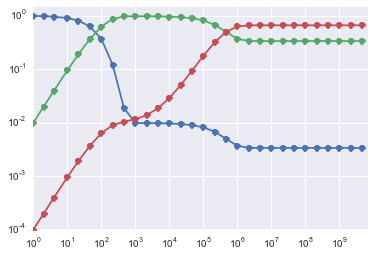

In [19]:
plt.loglog(counts, results, 'o-')
plt.margins(0.5)

We can also create a sequence of plots showing the evolution of the spectrum with $N$.

In [20]:
# dummy values for the frequencies
frequencies = [20, 15, 10]

In [21]:
len(results)

30

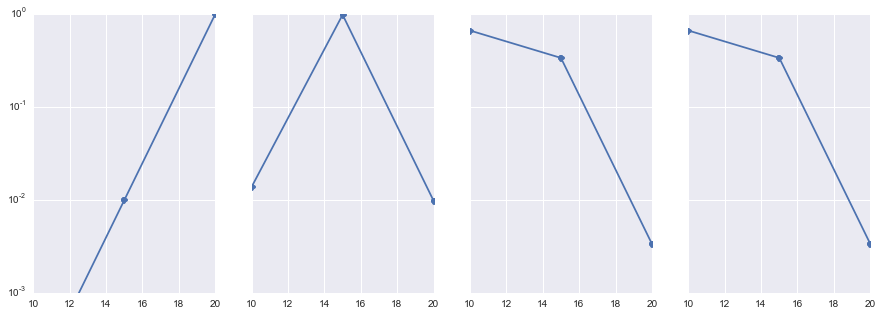

In [22]:
def render(i):
    plt.semilogy(frequencies, results[i], 'o-')

steps_to_show = [0, 10, 20, 29]
fig, axes = plt.subplots(ncols=len(steps_to_show), sharey=True, figsize=(15,5))
for i, ax in zip(steps_to_show, axes):
    plt.sca(ax)
    render(i)

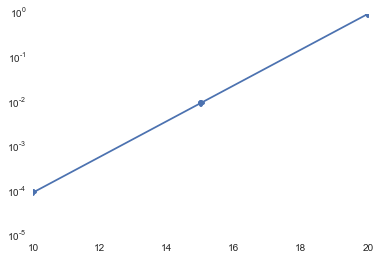

In [24]:
# animation is pretty iffy
a = anim.FuncAnimation(fig, render, frames=len(results))

This does the same thing for the second plot from the blog post. The difference here is the emission probabilities $P_{ji}$, which are set to
$$P_{ji} = w_j$$

In [23]:
absorb_weights = np.diag([
 # probability of absorbing a photon in state 0
 weights[0],
 # probability of absorbing a photon in state 1
 weights[1],
 # probability of absorbing a photon in state 2
 weights[2]
])
emit_weights = np.array([
 # probabilities of emitting a photon from state 0 back to...
 weights[[
  0, # state 0 (P_00)
  1, # state 1 (P_10)
  2  # state 2 (P_20)
 ]],
 # probabilities of emitting a photon from state 1 back to...
 weights[[
  0, # state 0 (P_01)
  1, # state 1 (P_11)
  2  # state 2 (P_21)
 ]],
 # probabilities of emitting a photon from state 2 back to...
 weights[[
  0, # state 0 (P_02)
  1, # state 1 (P_12)
  2  # state 2 (P_22)
 ]]
]).T

In [24]:
counts = [int(pow(10,n/3.)) for n in range(30)]
results = np.array([compute_with_transition_matrix([1,0,0], n, absorb_weights, emit_weights) for n in counts])

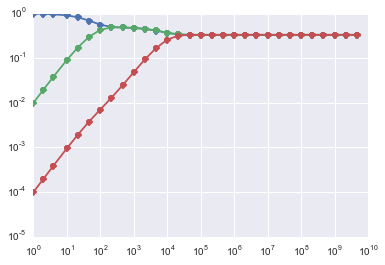

In [25]:
plt.loglog(counts, results, 'o-')

It's noteworthy (I think) that the pattern converges to a stable equilibrium for sufficiently large $N$. Presumably we can expect the same out of a test with more frequencies, and the end state should be the blackbody spectrum.

This also raises the possibility of reverse-engineering the transition matrix by assuming that the blackbody spectrum is its eigenstate.

#Using a Lorentzian spectrum 

Now we want to try the same thing using a Lorentzian absorption spectrum.

Suppose we have an atom with some number of spectral lines, indexed by $j$, with frequencies $\omega^{(j)}_\text{res}$ and widths $\gamma^{(j)}_\text{res}$.
The cross section for a photon to scatter off this atom is the sum of contributions from each resonant state.
Each contribution takes the form of the Lorentz distribution.
\begin{align}
\sigma^{(j)}_\text{abs}(\omega) &= \pi r_0 c f^{(j)} \frac{\gamma^{(j)}_\text{res}}{(\omega^{(j)}_\text{res} - \omega)^2 + (\gamma^{(j)}_\text{res})^2/4} \\
\sigma_\text{abs}(\omega) &= \sum_j \sigma^{(j)}(\omega)
\end{align}
For a thin layer of gas, the cross section relates to the absorption probability as
$$P^{(j)}_\text{abs}(\omega) = n\Delta x\sigma^{(j)}_\text{abs}(\omega) + \mathcal{O}(\Delta x^2)$$
where $n$ is the number of atoms per unit volume and $\Delta x$ is the thickness of the gas layer.
This is derived in e.g. [Wikipedia](http://en.wikipedia.org/wiki/Cross_section_%28physics%29#Quantum_scattering).

We also take the emission probability from a given resonant state to be a Lorentzian function of frequency.
$$\mathcal{P}^{(j)}_\text{emit}(\omega')
= \frac{1}{A^{(j)}} \frac{\gamma^{(j)}_\text{res}}{(\omega^{(j)}_\text{res} - \omega')^2 + (\gamma^{(j)}_\text{res})^2/4}$$
where $A^{(j)}$ is a normalization factor computed to satisfy $\int\mathcal{P}^{(j)}_\text{emit}(\omega')\mathrm{d}\omega' = 1$.
$$A^{(j)} = \pi + 2\tan^{-1}\frac{2\omega^{(j)}_\text{res}}{\gamma^{(j)}_\text{res}}$$

In [26]:
r0=2.8e-15
c=299792458
f=1
n = 0.1
Deltax = 0.01
prefactor = n*Deltax*np.pi*r0*c*f

In [27]:
resonances = [10]
widths = [1]
frequencies = np.array([0,1,2,3,4,5,6,7,8,9,
                        10,11,12,13,14,15,16,17,18,19,
                        20,22,24,26,28,30,32,34,36,38,
                        40,43,46,49,52,55,58,
                        61,64,68,72,76,
                        80,85,90,95,100,105,110,
                        np.inf])
# uniformly distributed initial state - probability proportional to bin size
initial_state = np.convolve(frequencies, [1,-1], 'valid')
initial_state[-1] = 0
initial_state /= initial_state.sum()

In [30]:
def lorentzian_absorption_probability(omega, state, args):
    omega_res, gamma_res = state
    v = prefactor * gamma_res / ((omega_res - omega)**2 + 0.25 * gamma_res**2)
    return v

absorb_weights = discretize_absorption(
    lorentzian_absorption_probability,
    frequencies,
    zip(resonances, widths))

In [31]:
def lorentzian_emission_probability(omega, state, args):
    omega_res, gamma_res = state
    return gamma_res / (
        ((omega_res - omega)**2 + 0.25 * gamma_res**2) *
        (np.pi + 2 * np.arctan(2 * omega_res / gamma_res))
        )

emit_weights = discretize_emission(
    lorentzian_emission_probability,
    frequencies,
    zip(resonances, widths))

In [32]:
check_conservation_condition(emit_weights)

True

Actually compute the results

In [35]:
counts = [int(pow(10,n/3.)) for n in range(40)]
results = np.array([compute_with_transition_matrix(initial_state, n, absorb_weights, emit_weights) for n in counts])

and make a plot

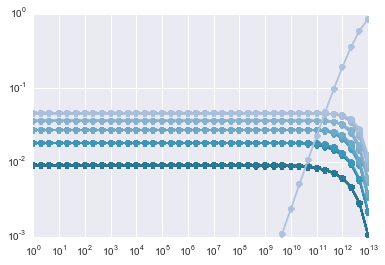

In [36]:
with sns.color_palette("PuBuGn_d", n_colors=results.shape[1]):
    plt.loglog(counts, results, 'o-')
    plt.ylim((1e-3,1))

Note the one curve that shoots up past the others around $10^8$.
That is the effect of the highest frequency interval, $(\omega_M, \infty)$, accumulating probability because high-frequency photons with $\omega > \omega_M$ are not absorbed.

Now let's try the procedure where we map all high-frequency photons $\omega > \omega_M$ to the highest frequency interval with $\omega < \omega_M$.

In [37]:
absorb_weights = discretize_absorption(
    lorentzian_absorption_probability,
    frequencies[:-1],
    zip(resonances, widths))
emit_weights = discretize_emission(
    lorentzian_emission_probability,
    frequencies[:-1],
    zip(resonances, widths))
emit_weights[-1] += 1 - emit_weights.sum(axis=0)
check_conservation_condition(emit_weights)

True

In [42]:
counts = [int(pow(10,n/3.)) for n in range(48)]
results = np.array([compute_with_transition_matrix(initial_state[:-1], n, absorb_weights, emit_weights) for n in counts])

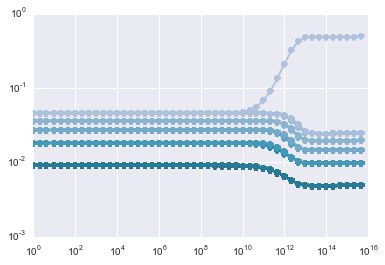

In [43]:
with sns.color_palette("PuBuGn_d", n_colors=results.shape[1]):
    plt.loglog(counts, results, 'o-')
    plt.ylim((1e-3,1))

The highest frequency bin still accumulates all the probability in the long term.

Let's try equal redistribution now:

In [44]:
absorb_weights = discretize_absorption(
    lorentzian_absorption_probability,
    frequencies[:-1],
    zip(resonances, widths))
emit_weights = discretize_emission(
    lorentzian_emission_probability,
    frequencies[:-1],
    zip(resonances, widths))
emit_weights /= emit_weights.sum(axis=0)
check_conservation_condition(emit_weights)

True

In [47]:
counts = [int(pow(10,n/3.)) for n in range(48)]
results = np.array([compute_with_transition_matrix(initial_state[:-1], n, absorb_weights, emit_weights) for n in counts])

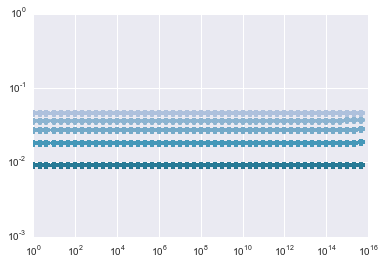

In [48]:
with sns.color_palette("PuBuGn_d", n_colors=results.shape[1]):
    plt.loglog(counts, results, 'o-')
    plt.ylim((1e-3,1))

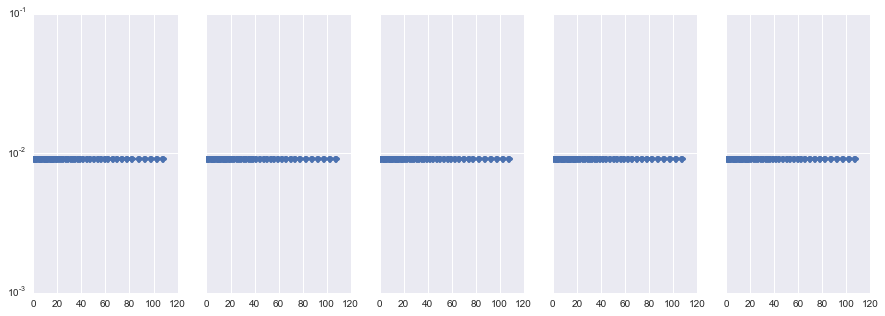

In [49]:
mean_frequencies = np.convolve(frequencies[:-1], [0.5,0.5], 'valid')
frequency_bin_widths = np.convolve(frequencies[:-1], [1,-1], 'valid')
def render(i):
    plt.semilogy(mean_frequencies, results[i] / frequency_bin_widths, 'o-')
    plt.ylim((1e-3,1e-1))

steps_to_show = [10, 15, 20, 25, 30]
fig, axes = plt.subplots(ncols=len(steps_to_show), sharey=True, figsize=(15,5))
for i, ax in zip(steps_to_show, axes):
    plt.sca(ax)
    render(i)

Evidently the transition matrix doesn't have any effect on a uniform distribution.

The frequency distributions that are unchanged by the transition matrix correspond to its eigenvectors. So it's worth taking a look at the eigenvectors and eigenvalues.

In [50]:
T = transition_matrix(absorb_weights, emit_weights)

In [51]:
eigvals, eigvecs = np.linalg.eig(T)

In [52]:
eigvals

array([ 1.        ,  0.99999999,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ])

Interestingly enough, all the eigenvalues are very close to $1$, and more to the point, pretty close to each other.
So the Lorentzian transition matrix with a single resonance is going to have very little effect on _any_ frequency distribution.

A look at the eigenvectors shows nothing particularly special:

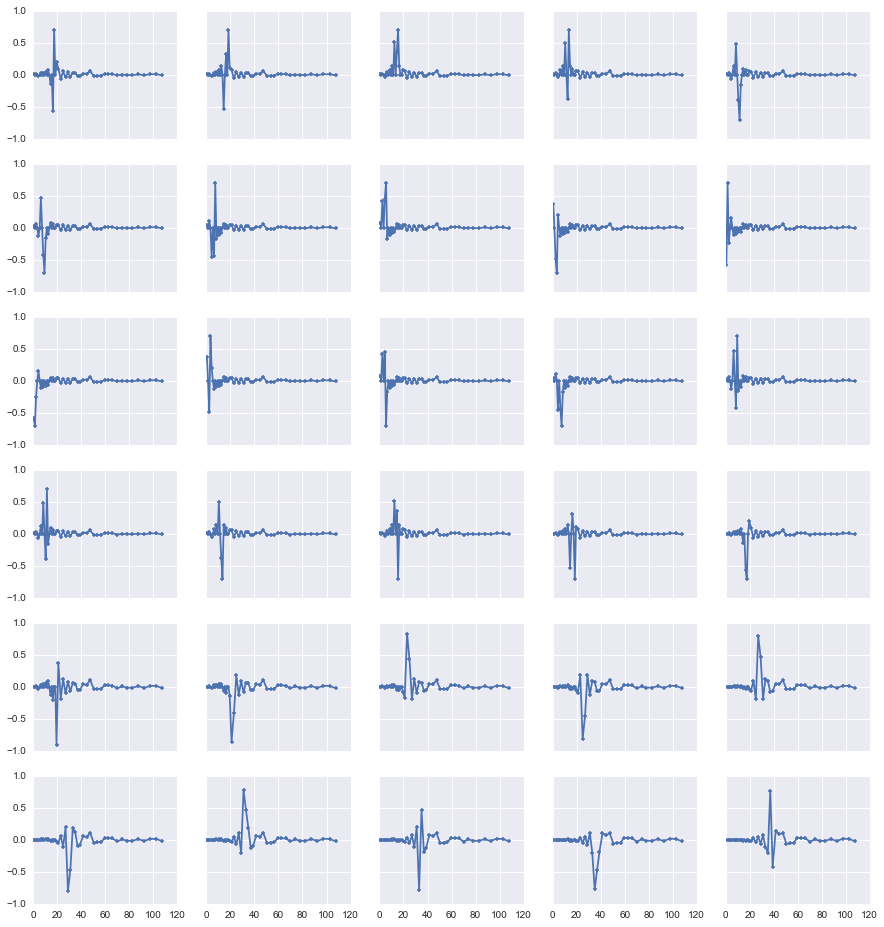

In [53]:
fig, axes = plt.subplots(ncols=5, nrows=6, sharey=True, sharex=True, figsize=(15,16))
for ax, v in zip(axes.flat, eigvecs):
    plt.sca(ax)
    plt.plot(mean_frequencies, v, '.-')

but on the other hand, we can see that a uniform spectrum $f(\omega)$ pretty much satisfies $T(\omega, \omega')f(\omega) = f(\omega')$.

In [54]:
np.isclose(T.dot(results[0]), results[0]).all()

True

And even after $10^8$ scatterings, the transition matrix still leaves the spectrum unchanged.

In [55]:
np.isclose(npla.matrix_power(T, 100000000).dot(results[0]), results[0]).all()

True

We can try adding some additional resonances to see if it changes anything

In [56]:
resonances = [10, 11, 15, 17, 19, 22, 25]
widths = [1, 1, 1, 1, 1, 1, 1]

absorb_weights = discretize_absorption(
    lorentzian_absorption_probability,
    frequencies[:-1],
    zip(resonances, widths))
emit_weights = discretize_emission(
    lorentzian_emission_probability,
    frequencies[:-1],
    zip(resonances, widths))
emit_weights /= emit_weights.sum(axis=0)
check_conservation_condition(emit_weights)

True

In [61]:
counts = [int(pow(10,n/3.)) for n in range(60)]
results = np.array([compute_with_transition_matrix(initial_state[:-1], n, absorb_weights, emit_weights) for n in counts])

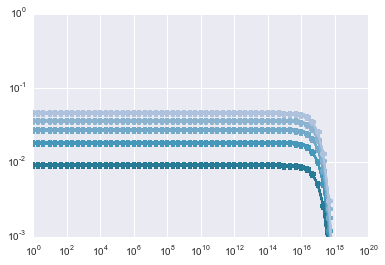

In [62]:
with sns.color_palette("PuBuGn_d", n_colors=results.shape[1]):
    plt.loglog(counts, results, 'o-')
    plt.ylim((1e-3,1))

Nope...

In [63]:
T = transition_matrix(absorb_weights, emit_weights)
eigvals, eigvecs = np.linalg.eig(T)
eigvals

array([ 0.99999999,  0.99999999,  0.99999999,  0.99999999,  0.99999999,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ])

We still have eigenvalues all nearly the same.

## Emitting at frequency absorbed

Let's try having a state for each frequency bin and re-emitting with a distribution centered at the same frequency that was absorbed (or at least the average frequency of the bin).
This corresponds to the probability functions
\begin{align}
P_{\text{abs}}^{(j)}(\omega) &= n\Delta x\pi r_0 c \sum_k f^{(k)} \frac{\gamma^{(k)}_\text{res}}{(\omega^{(k)}_\text{res} - \omega)^2 + (\gamma^{(k)}_\text{res})^2/4} w_j(\omega)
\\
\mathcal{P}_{\text{emit}}^{(j)}(\omega') &= \frac{1}{A} \frac{\gamma_\text{emit}^{(j)}}{(\omega_\text{emit}^{(j)} - \omega')^2 + (\gamma_\text{emit}^{(j)})^2/4}
\end{align}
where $\omega_\text{emit}^{(j)} = \frac{1}{2}(\omega_j + \omega_{j+1})$. Here the sum in the first expression runs over the resonances, not the frequency bins.

In [64]:
r0=2.8e-15
c=299792458
f=1
n = 0.1
Deltax = 0.01
prefactor = n*Deltax*np.pi*r0*c*f

In [65]:
def lorentzian_absorption_probability(omega, state, args):
    lower, upper = frequencies[[state, state+1]]
    if not (lower <= omega < upper):
        return 0
    v = prefactor * sum(
        gamma_res / ((omega_res - omega)**2 + 0.25 * gamma_res**2)
        for (omega_res, gamma_res)
        in zip(resonances, widths)
    )
    return v

absorb_weights = discretize_absorption(
    lorentzian_absorption_probability,
    frequencies,
    range(len(frequencies) - 1))

In [68]:
def lorentzian_emission_probability(omega, state, args):
    gamma_emit = 1
    lower, upper = frequencies[[state, state+1]]
    omega_mid = 0.5 * (lower + upper)
    return gamma_emit / (
        ((omega_mid - omega)**2 + 0.25 * gamma_emit**2) *
        (np.pi + 2 * np.arctan(2 * omega_mid / gamma_emit))
        )

emit_weights = discretize_emission(
    lorentzian_emission_probability,
    frequencies,
    range(len(frequencies) - 1))

In [72]:
counts = [int(pow(10,n/3.)) for n in range(45)]
results = np.array([compute_with_transition_matrix(initial_state, n, absorb_weights, emit_weights) for n in counts])

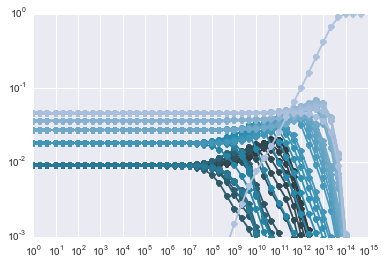

In [73]:
with sns.color_palette("PuBuGn_d", n_colors=results.shape[1]):
    plt.loglog(counts, results, 'o-')
    plt.ylim((1e-3,1))

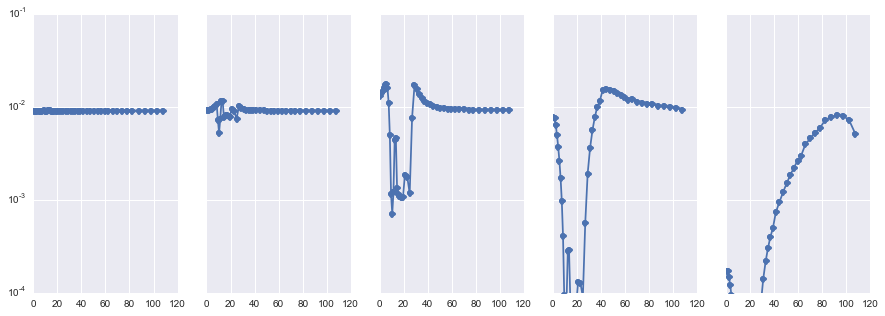

In [79]:
mean_frequencies = np.convolve(frequencies, [0.5,0.5], 'valid')
frequency_bin_widths = np.convolve(frequencies, [1,-1], 'valid')
def render(i):
    plt.semilogy(mean_frequencies, results[i] / frequency_bin_widths, 'o-')
    plt.ylim((1e-4,1e-1))

steps_to_show = [20,25,30,35,40]
fig, axes = plt.subplots(ncols=len(steps_to_show), sharey=True, figsize=(15,5))
for i, ax in zip(steps_to_show, axes):
    plt.sca(ax)
    render(i)

In [80]:
T = transition_matrix(absorb_weights, emit_weights)
eigvals, eigvecs = np.linalg.eig(T)
eigvals

array([ 1.        ,  0.99999999,  0.99999999,  0.99999999,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ])

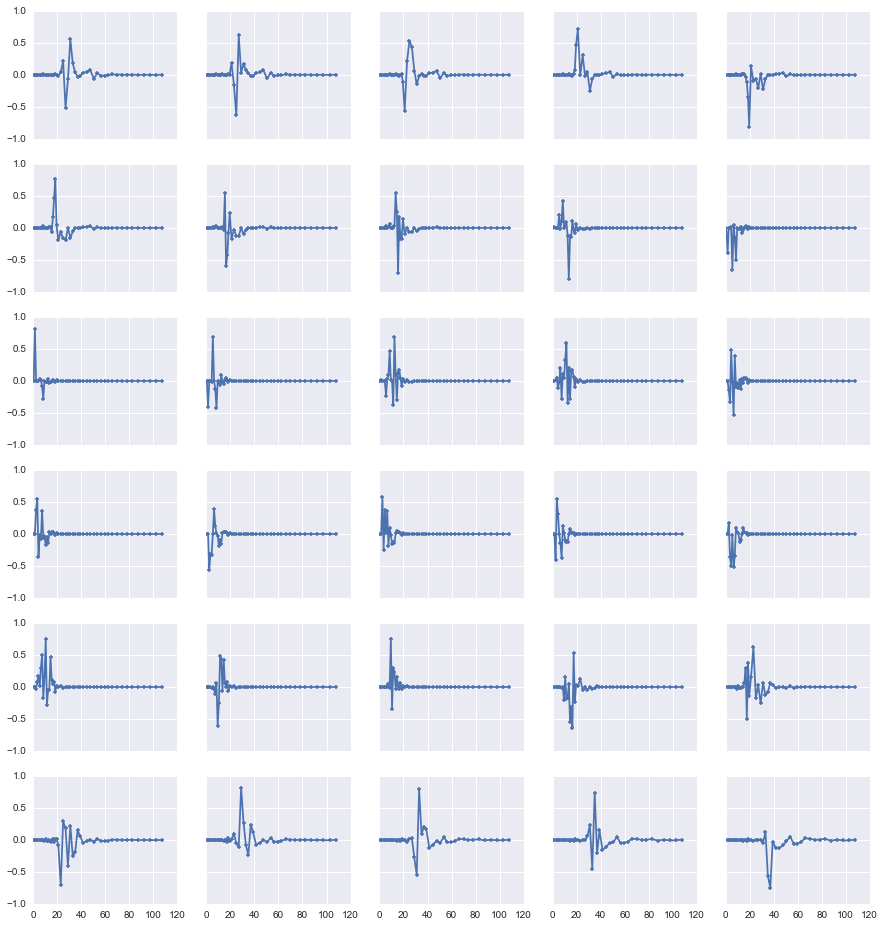

In [82]:
fig, axes = plt.subplots(ncols=5, nrows=6, sharey=True, sharex=True, figsize=(15,16))
for ax, v in zip(axes.flat, eigvecs):
    plt.sca(ax)
    plt.plot(mean_frequencies, v, '.-')

In [83]:
absorb_weights = discretize_absorption(
    lorentzian_absorption_probability,
    frequencies[:-1],
    range(len(frequencies) - 2))
emit_weights = discretize_emission(
    lorentzian_emission_probability,
    frequencies[:-1],
    range(len(frequencies) - 2))
emit_weights /= emit_weights.sum(axis=0)
check_conservation_condition(emit_weights)

True

In [85]:
counts = [int(pow(10,n/3.)) for n in range(48)]
results = np.array([compute_with_transition_matrix(initial_state[:-1], n, absorb_weights, emit_weights) for n in counts])

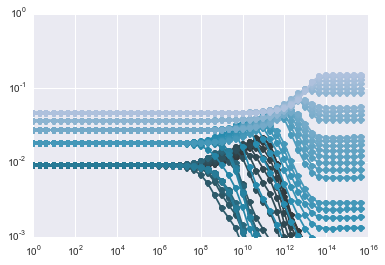

In [86]:
with sns.color_palette("PuBuGn_d", n_colors=results.shape[1]):
    plt.loglog(counts, results, 'o-')
    plt.ylim((1e-3,1))

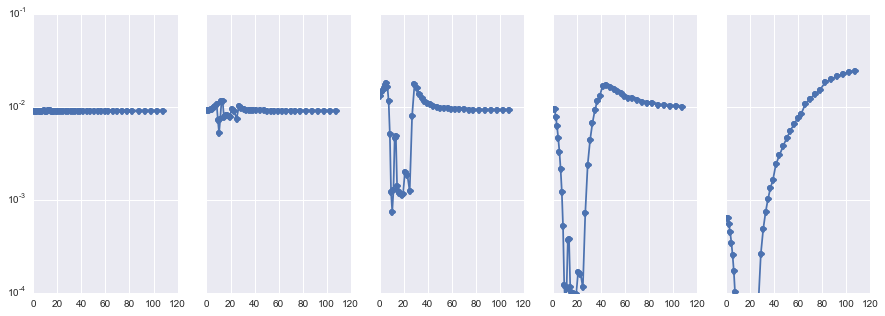

In [88]:
mean_frequencies = np.convolve(frequencies[:-1], [0.5,0.5], 'valid')
frequency_bin_widths = np.convolve(frequencies[:-1], [1,-1], 'valid')
def render(i):
    plt.semilogy(mean_frequencies, results[i] / frequency_bin_widths, 'o-')
    plt.ylim((1e-4,1e-1))

steps_to_show = [20,25,30,35,40]
fig, axes = plt.subplots(ncols=len(steps_to_show), sharey=True, figsize=(15,5))
for i, ax in zip(steps_to_show, axes):
    plt.sca(ax)
    render(i)

For comparison, this is what we're looking for, the blackbody spectrum

# Ignore this

The matrix elements for a continuous spectrum of internal states are defined by
\begin{align}
P_{ji}^\text{a}
&= \iint \frac{w_i(\omega)}{\omega_{i+1} - \omega_{i}} w_j(\omega_{j'}) \mathcal{P}_\text{abs}(\omega, \omega_{j'})\,\mathrm{d}\omega\,\mathrm{d}\omega_{j'}\tag{4a} \\
P_{kj}^\text{e}
&= \iint w_k(\omega') w_j(\omega_{j'}) \mathcal{P}_\text{emit}(\omega', \omega_{j'})\,\mathrm{d}\omega'\,\mathrm{d}\omega_{j'}\tag{4b} \\
T_{ki}
&= \int \frac{w_i(\omega)}{\omega_{i+1} - \omega_{i}} w_k(\omega') \mathcal{T}(\omega, \omega')\,\mathrm{d}\omega\,\mathrm{d}\omega'\tag{4c}
\end{align}
where the transition probability is
$$\mathcal{T}(\omega, \omega')\,\mathrm{d}\omega' = \int \mathcal{P}_\text{emit}(\omega', \omega_j) \mathcal{P}_\text{abs}(\omega, \omega_j)\,\mathrm{d}\omega_j\,\mathrm{d}\omega' + \delta(\omega - \omega')\biggl(1 - \int \mathcal{P}_\text{abs}(\omega, \omega_j)\,\mathrm{d}\omega_j\biggr)\mathrm{d}\omega'$$